In [1]:
import scipy.io as scio
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import pickle
import cv2
from tensorflow.python.client import device_lib
import math
import pandas as pd
device_lib.list_local_devices()
import shutil
import pathlib
import random
import sys
import colorsys
import copy
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K
import gc
import sklearn
np.random.seed(2023)
random.seed(2023)

In [2]:
N_data=scio.loadmat(r"D:\AI in NTU\Proffu\OneDrive-2024-01-29\3D_Dome_Simulation_Data_Z_axis.mat")
#Results_shape:(12,250,1600,46) 12是12个敲击位置，46是传感器序号，1600是时间序列，250是250个level的力
#sensor_hub FEM的结果 = [61;18;24;29;34;37;41;45;47;51;54];  % Sensor 1 to 11
#######最大值在110， 【0，1600】
Results_1 = np.array(N_data['Results_Z1'])
Results_2 = np.array(N_data['Results_Z2'])[12:]
Results_3 = np.array(N_data['Results_Z3'])[24:]
Results_4 = np.array(N_data['Results_Z4'])[36:]
Results = np.concatenate((Results_1,Results_2,Results_3,Results_4),axis=0)
##########制作数据集#####
Time_series = []
Force=[]
Location=[]
sensor_hub = np.array([61,18,24,29,34,37,41,45,47,51,54])-16

for i in range(46):
    for j in range(250):
        Time_series.append(Results[i][j][:,sensor_hub])
        Force.append([(j+1)*2])
        Location.append(tf.one_hot(i,46))
        #Location.append([Ind[i]//3])#3个为一个点

Time_series = np.array(Time_series)
Force=np.array(Force)
Location=np.array(Location)
####shuffle
listindex=np.array([i for i in range(len(Time_series))])
np.random.shuffle(listindex)

Time_series = Time_series[listindex]
Force=Force[listindex]
Location=Location[listindex]
####preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler_T = StandardScaler()
#scaler_F = MinMaxScaler()
Time_series = scaler_T.fit_transform(Time_series.reshape(-1,1)).reshape(-1,1600,11)
#Force = scaler_F.fit_transform(Force.reshape(-1,1)).reshape(-1,1)

In [3]:
Temp_list = np.arange(0,len(Time_series))
np.random.shuffle(Temp_list)
Time_series = Time_series[Temp_list]
Force =Force[Temp_list]
Location = Location[Temp_list]
Train_Time_series,Test_Time_Series = Time_series[:int(0.8*len(Time_series))], Time_series[int(0.8*len(Time_series)):]
Train_Force, Test_Force = Force[:int(0.8*len(Time_series))],Force[int(0.8*len(Time_series)):]
Train_Location,Test_Location = Location[:int(0.8*len(Time_series))],Location[int(0.8*len(Time_series)):]

In [4]:
data_test1=scio.loadmat(r'D:\AI in NTU\Proffu\Processed_Dataset_Test_1_16384.mat')
data_test2=scio.loadmat(r'D:\AI in NTU\Proffu\Processed_Dataset_Test_2_16384.mat')
data_test3=scio.loadmat(r'D:\AI in NTU\Proffu\Processed_Dataset_Test_3_16384.mat')
data_test4=scio.loadmat(r'D:\AI in NTU\Proffu\Processed_Dataset_Test_4_16384.mat')
data_test5=scio.loadmat(r'D:\AI in NTU\Proffu\Processed_Dataset_Test_5_16384.mat')
data_test6=scio.loadmat(r'D:\AI in NTU\Proffu\Processed_Dataset_Test_6_16384.mat')

Force_test1 = np.abs(np.array(data_test1['force']))
resp_test1 = np.array(data_test1['resp'])
Force_test2 = np.abs(np.array(data_test2['force']))
resp_test2 = np.array(data_test2['resp'])
Force_test3 = np.abs(np.array(data_test3['force']))
resp_test3 = np.array(data_test3['resp'])
Force_test4 = np.abs(np.array(data_test4['force']))
resp_test4 = np.array(data_test4['resp'])
Force_test5 = np.abs(np.array(data_test5['force']))
resp_test5 = np.array(data_test5['resp'])
Force_test6 = np.abs(np.array(data_test6['force']))
resp_test6 = np.array(data_test6['resp'])
#resp.shape：72091, 33, 15
#Test 1 to 6 is [15;15;15;6;6;7].
#sensor_hub = [61;18;24;29;34;37;41;45;47;51;54];  % Sensor 1 to 11
#The order of 33 channels is: sensor_1_X, sensor_1_Y, sensor_1_Z, sensor_2_X, sensor_2_Y, sensor_2_Z, ...
#hammer_hub = [32;39;44;33;50;52];                 % Test 1 to 6
#####力的最大值在时间序列的3273-3274,降采样后在210
#F = 16384 Hz.
Real_F = 16384 
def down_sample(Real_F,Out_F,time_seires):
    num = int(Real_F/Out_F)
    out_time_series = []
    for i in range(int(len(time_seires)/num)):
        out_time_series.append(np.sum(time_seires[i*num:(i+1)*num],axis=0)/num)
    return out_time_series

Time_series_R = []
Force_R=[]
Location_R=[]
Z_list = [(i*3+2) for i in range(11)]
for i in range(15):
    Time_series_R.append(np.array(down_sample(16384 ,1001,resp_test1[...,Z_list,i])[100:1700]))
    Force_R.append([np.max(Force_test1[...,i])*4.4482216153])
    Location_R.append(tf.one_hot(32-16,46))

for i in range(15):
    Time_series_R.append(np.array(down_sample(16384 ,1001,resp_test2[...,Z_list,i])[100:1700]))
    Force_R.append([np.max(Force_test2[...,i])*4.4482216153])
    Location_R.append(tf.one_hot(39-16,46))
    
for i in range(15):
    Time_series_R.append(np.array(down_sample(16384 ,1001,resp_test3[...,Z_list,i])[100:1700]))
  
    Force_R.append([np.max(Force_test3[...,i])*4.4482216153])
    Location_R.append(tf.one_hot(44-16,46))
    
for i in range(6):
    Time_series_R.append(np.array(down_sample(16384 ,1001,resp_test4[...,Z_list,i])[100:1700]))
    Force_R.append([np.max(Force_test4[...,i])*4.4482216153])
    Location_R.append(tf.one_hot(33-16,46))

for i in range(6):
    Time_series_R.append(np.array(down_sample(16384 ,1001,resp_test5[...,Z_list,i])[100:1700]))
    Force_R.append([np.max(Force_test5[...,i])*4.4482216153])
    Location_R.append(tf.one_hot(50-16,46))

for i in range(7):
    Time_series_R.append(np.array(down_sample(16384 ,1001,resp_test6[...,Z_list,i])[100:1700]))
    Force_R.append([np.max(Force_test6[...,i])*4.4482216153])
    Location_R.append(tf.one_hot(52-16,46))

Time_series_R = np.array(Time_series_R)
Force_R=np.array(Force_R)
Location_R=np.array(Location_R)
####shuffle
listindex_r=np.array([i for i in range(len(Time_series_R))])
np.random.shuffle(listindex_r)

Time_series_R = Time_series_R[listindex_r]

Force_R=Force_R[listindex_r]
Location_R=Location_R[listindex_r]
####preprocessing
Time_series_R = scaler_T.transform(Time_series_R.reshape(-1,1)).reshape(-1,1600,11)  
#Force_R = scaler_F.transform(Force_R.reshape(-1,1)).reshape(-1,1)  

In [5]:
#F = 16384 Hz.
Real_F = 16384 
def down_sample(Real_F,Out_F,time_seires):
    num = int(Real_F/Out_F)
    out_time_series = []
    for i in range(int(len(time_seires)/num)):
        out_time_series.append(np.sum(time_seires[i*num:(i+1)*num],axis=0)/num)
    return out_time_series

def RealDataTransfer(filepath):
    #sensor_hub = [61;18;24;29;34;37;41;45;47;51;54];  
    yxz=np.deg2rad([96.0329,11.7791,11,1932,8.4425,31.3788,28.2175,32.5597,32.2324,50.9689,51.2068,51.6366])
    yyz=np.deg2rad([95.5724,90.0802,89.1031,87.9083,74.3946,74.9639,97.3785,83.8930,88.8065,91.9637,72.5100])
    yzz=np.deg2rad([8.2268,78.2212,78.8437,81.8244,63.5242,66.7158,58.4911,58.4907,39.0565,38.8621,43.5972])
    data=scio.loadmat(filepath)
    DATA_Z =[]
    for i in range(11):
        DATA=[]
        for j in range(1,4):
            if j==1:
                s = "X"
                factor = np.cos(yxz[i])
            elif j==2:
                s = "Y"
                factor = np.cos(yyz[i])
            else:
                s = "Z"
                factor = np.cos(yzz[i])
            if (i+1)<10:
                name_temp = 'MAT_' + '%03d'%(j+3*i)+ '_Time_record_Sensor_' + str(i+1) +'_' + s + '_'
            else:
                 name_temp = 'MAT_' + '%03d'%(j+3*i)+ '_Time_record_Sensor_' + str(i+1) +'_' + s
            DATA.append(np.array(data[name_temp])[:,1].real*factor)
        DATA = np.array(DATA)[...,np.newaxis]
        DATA_Z.append(np.sum(DATA,axis=0))
    Data_Z_Final = DATA_Z[0] 
    for i in range(1,len(DATA_Z)):
        Data_Z_Final = np.concatenate((Data_Z_Final,DATA_Z[i]),axis=-1)
    Data_Z_Final = np.array(down_sample(Real_F,1001,Data_Z_Final))[300:1900,:]
    Force = np.max(np.abs(np.array(data['MAT_034_Time_record_Hammer_'][:,1]).real))*1000*4.4482216153
    return Data_Z_Final,Force

In [6]:
##############Healthy_State_Jun06###############
File_dir = r"D:\AI in NTU\Proffu\OneDrive-2024-01-30\Healthy_State_Jun06"
all_file = []
Time_June = []
Force_June = []
Location_June =[]
Ind_June = [16,17,19,20,21,26,27,28,30,31,32,33,35,42,43,44,46,48,53,55]
for i in range(1,21):
    for j in range(1,4):
        #all_file.append(File_dir+"\\Hammer_Test_"+ str(i) +"_0" + str(j) + ".mat")
        Dat, Forc = RealDataTransfer(File_dir+"\\Hammer_Test_"+ str(i) +"_0" + str(j) + ".mat")
        Time_June.append(Dat)
        Force_June.append([Forc])
        Location_June.append(tf.one_hot(Ind_June[i-1]-16,46))
Time_June = np.array(Time_June)
Force_June = np.array(Force_June)
Location_June =np.array(Location_June)
####preprocessing
Time_June = scaler_T.transform(Time_June.reshape(-1,1)).reshape(-1,1600,11)  
#Force_June = scaler_F.transform(Force_June.reshape(-1,1)).reshape(-1,1)  
##############Healthy_State###############
File_dir = r"D:\AI in NTU\Proffu\OneDrive-2024-01-30\Healthy_State"
Ind_New = [16,17,19,20,21,26,27,28,30,31,32,33,35,42,43,44,46,48,53,55,16,17,19,20,21,26,27,28,30,31,32,33,35,42,43,44,46,48,53,55]
all_file = []
Time_New = []
Force_New = []
Location_New =[]
for i in range(1,21):
    for j in range(1,11):
        if j <10 :
            Dat, Forc = RealDataTransfer(File_dir+"\\Hammer_Test_"+ str(i) +"_0" + str(j) + ".mat")
        else:
            Dat, Forc = RealDataTransfer(File_dir+"\\Hammer_Test_"+ str(i) +"_" + str(j) + ".mat")
        Time_New.append(Dat)
        Force_New.append([Forc])
        Location_New.append(tf.one_hot(Ind_New[i-1]-16,46))
for i in range(21,41):
    for j in range(1,4):
        Dat, Forc = RealDataTransfer(File_dir+"\\Hammer_Test_"+ str(i) +"_0" + str(j) + ".mat")
        Time_New.append(Dat)
        Force_New.append([Forc])
        Location_New.append(tf.one_hot(Ind_New[i-1]-16,46))
Time_New = np.array(Time_New)
Force_New = np.array(Force_New)
Location_New = np.array(Location_New)     
####preprocessing
Time_New = scaler_T.transform(Time_New.reshape(-1,1)).reshape(-1,1600,11)  
#Force_New = scaler_F.transform(Force_New.reshape(-1,1)).reshape(-1,1)  

In [7]:
Real_ALL_Time = np.concatenate((Time_series_R,Time_June,Time_New),axis=0)
Real_ALL_Force = np.concatenate((Force_R,Force_June,Force_New ),axis=0)
Real_ALL_Location =  np.concatenate((Location_R,Location_June,Location_New),axis=0)
Temp_list_Real = np.arange(0,len(Real_ALL_Time))
np.random.shuffle(Temp_list_Real)
Real_ALL_Time = Real_ALL_Time[Temp_list_Real]
Real_ALL_Location =Real_ALL_Location[Temp_list_Real]
Real_ALL_Force = Real_ALL_Force[Temp_list_Real]

Train_Real_ALL_Time,Test_Real_ALL_Time = Real_ALL_Time[:int(0.8*len(Real_ALL_Time))], Real_ALL_Time[int(0.8*len(Real_ALL_Time)):]
Train_Real_ALL_Force, Test_Real_ALL_Force = Real_ALL_Force[:int(0.8*len(Real_ALL_Time))],Real_ALL_Force[int(0.8*len(Real_ALL_Time)):]
Train_Real_ALL_Location,Test_Real_ALL_Location = Real_ALL_Location[:int(0.8*len(Real_ALL_Time))],Real_ALL_Location[int(0.8*len(Real_ALL_Time)):]

In [8]:
ALL_Time = np.concatenate((Train_Time_series,Train_Real_ALL_Time),axis=0)
ALL_Force = np.concatenate((Train_Force,Train_Real_ALL_Force),axis=0)
All_Location = np.concatenate((Train_Location,Train_Real_ALL_Location),axis=0)
Temp_list_ALL= np.arange(0,len(ALL_Time))
np.random.shuffle(Temp_list_ALL)
ALL_Time = ALL_Time[Temp_list_ALL]
ALL_Force  = ALL_Force [Temp_list_ALL]
All_Location = All_Location[Temp_list_ALL]

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
from tensorflow import keras, data
from tensorflow.keras import layers, regularizers, activations
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import scipy
from scipy.fft import fft,ifft
import math

class New_Impact_Discrimination(tf.keras.Model):
    def __init__(self,dim=64):
        super(New_Impact_Discrimination, self).__init__()
        self.embeddinglayer = tf.keras.layers.Dense(dim, activation="relu",)
        self.LSTM1 = tf.keras.layers.LSTM(128, activation="tanh",return_sequences=True)
        self.LSTM2 = tf.keras.layers.LSTM(128, activation="tanh",return_sequences=True)
               
        self.Conv1  =tf.keras.layers.Conv1D(64, 3, activation="relu", strides=1, padding="same")
        self.MaxPool1 = tf.keras.layers.MaxPool1D (pool_size=2, strides=2)
        self.Conv2 = tf.keras.layers.Conv1D(64, 3, activation="relu", strides=1, padding="same")
        self.MaxPool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Conv3 = tf.keras.layers.Conv1D(128, 3, activation="relu", strides=1, padding="same")
        self.MaxPool3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.Flatten = tf.keras.layers.Flatten()
   
        self.block1 =[]
        for i in range(3):
            self.block1.append([
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.BatchNormalization(),
            ])

        self.block2 =[]
        for i in range(3):
            self.block2.append([
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.BatchNormalization()
            ])
        
        self.F = tf.keras.layers.Dense(1, activation="relu")
        self.L = tf.keras.layers.Dense(46, activation="softmax")
  
    def call(self, inputs, training=True):
        x  = inputs
        x1 = self.embeddinglayer(x)
        x2 = self.LSTM1(x1)
        x3 = self.LSTM2(x2)
        x4 = self.Conv1(x3)
        x5 = self.MaxPool1(x4)
        x6 = self.Conv2(x5)
        x7 = self.MaxPool2(x6)
        x8 = self.Conv3(x7)
        x9 = self.MaxPool3(x8)
        x10 = self.Flatten(x9)
        x_f = x10
        x_l = x10
     
        for Dense, Batchnorm in self.block1:
            x_f1 = Dense(x_f)
            x_f2 = Batchnorm(x_f1)
            x_f = tf.keras.layers.add([x_f1, x_f2])
        Output1 = self.F(x_f)

        for Dense, Batchnorm in self.block2:
            x_l1 = Dense(x_l)
            x_l2 = Batchnorm(x_l1)
            x_l = tf.keras.layers.add([x_l1, x_l2])  
        Output2 = self.L(x_l)
       
        return Output1, Output2

In [12]:
#########################Part A########################
np.random.seed(2023)
batch = 4
model =New_Impact_Discrimination()
model.build((None,1600,11))
model.load_weights("./DirectMix_NewAll.h5")
out_put_model_file = "./DirectMix_NewAll.h5"
Callbacks=[
    tf.keras.callbacks.ModelCheckpoint(out_put_model_file,save_best_only=True,save_weights_only =True),
    tf.keras.callbacks.EarlyStopping(patience=10,min_delta=1e-3),
]
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss=[tf.keras.losses.MAE,tf.keras.losses.categorical_crossentropy])
history = model.fit(x =ALL_Time, y=[ALL_Force,All_Location], epochs=50,batch_size=batch,validation_split=0.7,callbacks=Callbacks)

Epoch 1/50
713/713 [==============================] - 209s 289ms/step - loss: 9.7415 - output_1_loss: 8.4433 - output_2_loss: 1.2982 - val_loss: 13.6944 - val_output_1_loss: 11.4338 - val_output_2_loss: 2.2606
Epoch 2/50
713/713 [==============================] - 213s 298ms/step - loss: 9.5752 - output_1_loss: 8.3225 - output_2_loss: 1.2527 - val_loss: 10.1533 - val_output_1_loss: 9.0756 - val_output_2_loss: 1.0776
Epoch 3/50
713/713 [==============================] - 214s 301ms/step - loss: 9.5644 - output_1_loss: 8.3356 - output_2_loss: 1.2288 - val_loss: 13.7616 - val_output_1_loss: 12.7063 - val_output_2_loss: 1.0553
Epoch 4/50
713/713 [==============================] - 208s 292ms/step - loss: 9.0598 - output_1_loss: 7.8942 - output_2_loss: 1.1656 - val_loss: 9.9263 - val_output_1_loss: 8.5722 - val_output_2_loss: 1.3541
Epoch 5/50
713/713 [==============================] - 212s 297ms/step - loss: 8.7714 - output_1_loss: 7.6533 - output_2_loss: 1.1182 - val_loss: 10.0372 - val_outp

[[43  0  0 ...  0  0  0]
 [ 0 38  0 ...  0  0  0]
 [ 0  0 52 ...  0  0  0]
 ...
 [ 0  0  0 ... 48  0  0]
 [ 0  0  0 ... 11 41  2]
 [ 0  0  0 ...  0  0 29]]
0.8304347826086956
0.8723115477550913
0.8304347826086956
0.816000077176111


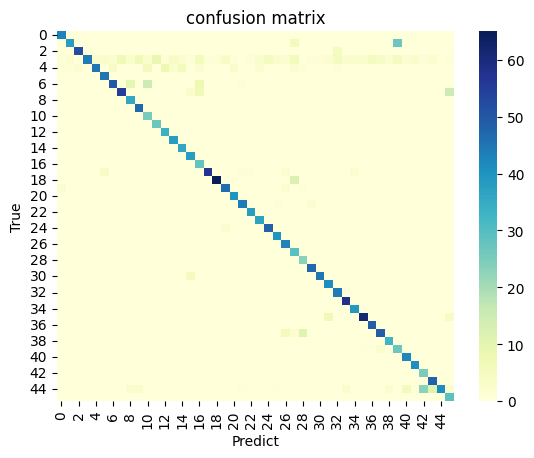

In [12]:
###############测试下#######################
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.random.seed(2023)
batch = 4
model =New_Impact_Discrimination()
model.build((None,1600,11))
model.load_weights("./DirectMix_NewAll.h5")

y_predicted_L = []
y_Real_L = []
Force_p = []
Force_r = []
for count in range(int(len(Test_Time_Series)/4)):
    X =Test_Time_Series[4*count:4*(count+1)]
    F,L = model(X)
    y_predicted_L.extend(np.argmax(L,axis=-1))
    y_Real_L.extend(np.argmax(Test_Location[4*count:4*(count+1)],axis=-1))
    Force_p.extend(F)
    Force_r.extend(Test_Force[4*count:4*(count+1)])
    
f,ax = plt.subplots()
y_true = np.squeeze(y_predicted_L)
y_pred = np.squeeze(y_Real_L)
C2 = confusion_matrix(y_true,y_pred,labels= [i for i in range(0,46)])
print(C2)
sns.heatmap(C2,annot=False,ax=ax,cmap="YlGnBu") #画热力图
ax.set_title('confusion matrix') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴
print(sklearn.metrics.accuracy_score(y_true, y_pred))
print(sklearn.metrics.precision_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.recall_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.f1_score(y_true, y_pred,average='weighted'))

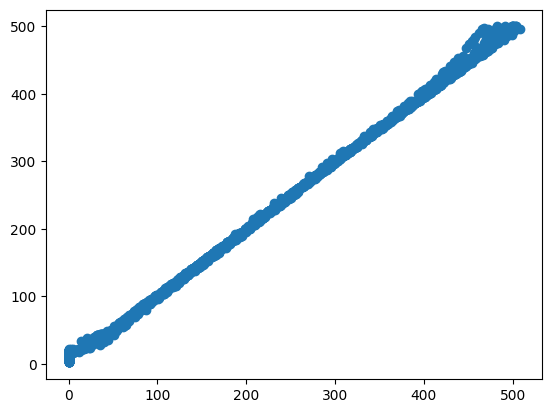

0.058654048471327505


In [13]:
plt.scatter(x=np.squeeze(Force_p),y=np.squeeze(Force_r))
plt.show()
print(sklearn.metrics.mean_absolute_percentage_error(np.squeeze(Force_r), np.squeeze(Force_p)))
SAVEDATA = pd.DataFrame(np.concatenate((np.squeeze(Force_p),np.squeeze(Force_r)),axis=-1))
SAVEDATA.to_excel(r"D:\AI in NTU\Proffu\Results\DT_N.xlsx")

[[0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.21052631578947367
0.4934210526315789
0.21052631578947367
0.26681286549707606


D:\Anaconda\envs\Tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\Tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


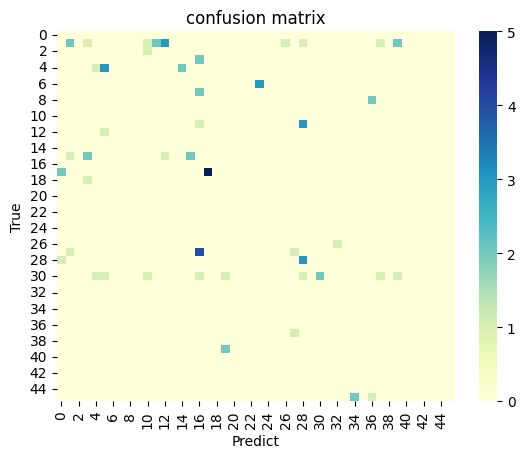

In [14]:
##############测试下#######################
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.random.seed(2023)
batch = 4
model =New_Impact_Discrimination()
model.build((None,1600,11))
model.load_weights("./DirectMix_NewAll.h5")

y_predicted_L = []
y_Real_L = []
Force_p = []
Force_r = []
for count in range(int(len(Test_Real_ALL_Time )/4)):
    X = Test_Real_ALL_Time [4*count:4*(count+1)]
    F,L = model(X)
    y_predicted_L.extend(np.argmax(L,axis=-1))
    y_Real_L.extend(np.argmax(Test_Real_ALL_Location[4*count:4*(count+1)],axis=-1))
    Force_p.extend(F)
    Force_r.extend(Test_Real_ALL_Force[4*count:4*(count+1)])
    
f,ax = plt.subplots()
y_true = np.squeeze(y_predicted_L)
y_pred = np.squeeze(y_Real_L)
C2 = confusion_matrix(y_true,y_pred,labels= [i for i in range(0,46)])
print(C2)
sns.heatmap(C2,annot=False,ax=ax,cmap="YlGnBu") #画热力图
ax.set_title('confusion matrix') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴
print(sklearn.metrics.accuracy_score(y_true, y_pred))
print(sklearn.metrics.precision_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.recall_score(y_true, y_pred,average='weighted'))
print(sklearn.metrics.f1_score(y_true, y_pred,average='weighted'))

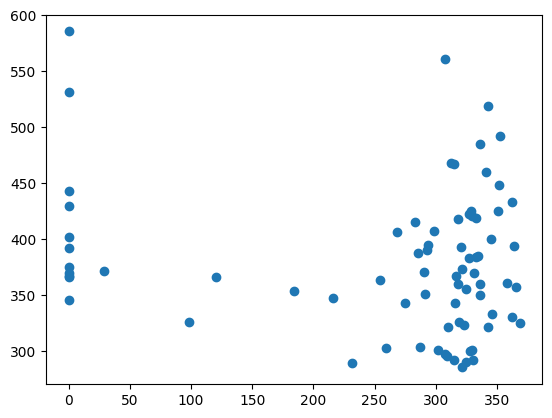

0.3132664379539888


In [15]:
plt.scatter(x=np.squeeze(Force_p),y=np.squeeze(Force_r))
plt.show()
print(sklearn.metrics.mean_absolute_percentage_error(np.squeeze(Force_r), np.squeeze(Force_p)))
SAVEDATA = pd.DataFrame(np.concatenate((np.squeeze(Force_p),np.squeeze(Force_r)),axis=-1))
SAVEDATA.to_excel(r"D:\AI in NTU\Proffu\Results\DT_R.xlsx")